In [1]:
# Import required libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

Load the thermal images

In [2]:
# Define file paths
faulty_img_path = "/home/hasitha/hasitha_codebase/ViT-Playground/repos/ArbitAI-fastapi-service/data/thermal_images/T1/faulty/T1_faulty_029.jpg"
normal_img_path = "/home/hasitha/hasitha_codebase/ViT-Playground/repos/ArbitAI-fastapi-service/data/thermal_images/T1/normal/T1_normal_005.jpg"

# Load images
faulty_img = cv2.imread(faulty_img_path)
normal_img = cv2.imread(normal_img_path)

# Convert from BGR to RGB for display
faulty_img_rgb = cv2.cvtColor(faulty_img, cv2.COLOR_BGR2RGB)
normal_img_rgb = cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB)

# Get image dimensions
print(f"Faulty image shape: {faulty_img.shape}")
print(f"Normal image shape: {normal_img.shape}")

Faulty image shape: (640, 640, 3)
Normal image shape: (640, 640, 3)


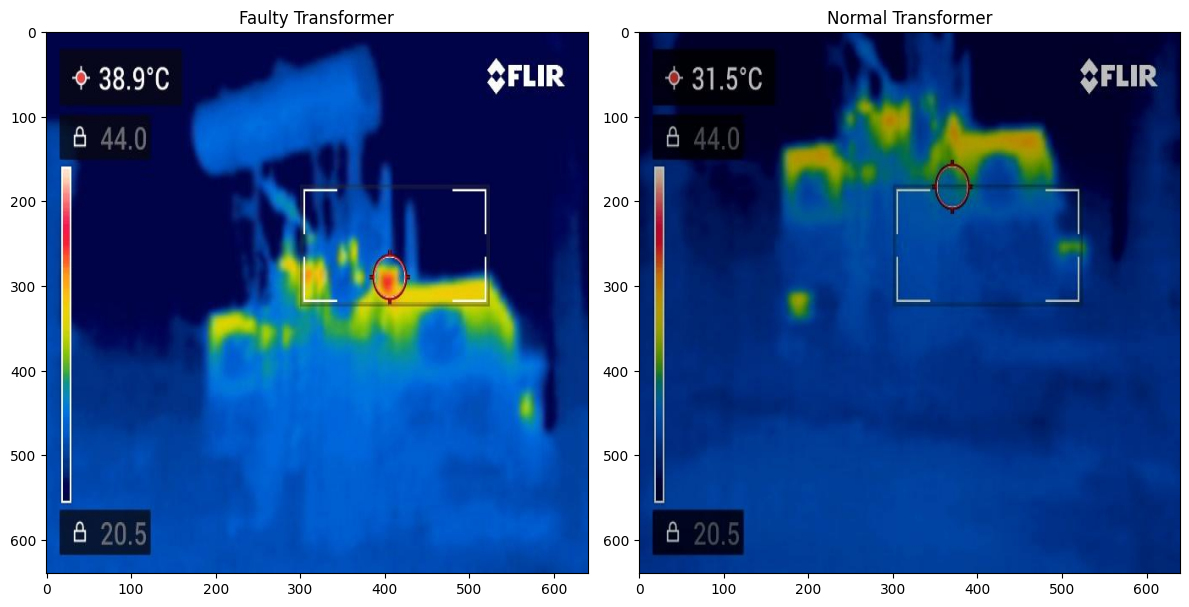

In [3]:
# Plot original images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Faulty Transformer")
plt.imshow(faulty_img_rgb)
plt.axis('on')

plt.subplot(1, 2, 2)
plt.title("Normal Transformer")
plt.imshow(normal_img_rgb)
plt.axis('on')

plt.tight_layout()
plt.show()

In [4]:
def crop_thermal_image(img):
    """
    Crop thermal image to remove borders, text, and thermal scale.
    This function assumes thermal scale is typically on the right side.
    Adjust parameters as needed based on actual image layout.
    """
    height, width = img.shape[:2]
    
    # Estimate crop boundaries (adjust these values based on your images)
    # These are starting points - you'll need to fine-tune for your specific images
    top_crop = int(height * 0.1)  # Remove top 10%
    bottom_crop = int(height * 0.9)  # Remove bottom 10%
    left_crop = int(width * 0.1)  # Remove left 10%
    right_crop = int(width * 0.8)  # Remove right 20% (assuming thermal scale is here)
    
    # Crop the image
    cropped_img = img[top_crop:bottom_crop, left_crop:right_crop]
    
    return cropped_img

# Crop both images
faulty_cropped = crop_thermal_image(faulty_img)
normal_cropped = crop_thermal_image(normal_img)

# Convert cropped images to RGB for display
faulty_cropped_rgb = cv2.cvtColor(faulty_cropped, cv2.COLOR_BGR2RGB)
normal_cropped_rgb = cv2.cvtColor(normal_cropped, cv2.COLOR_BGR2RGB)

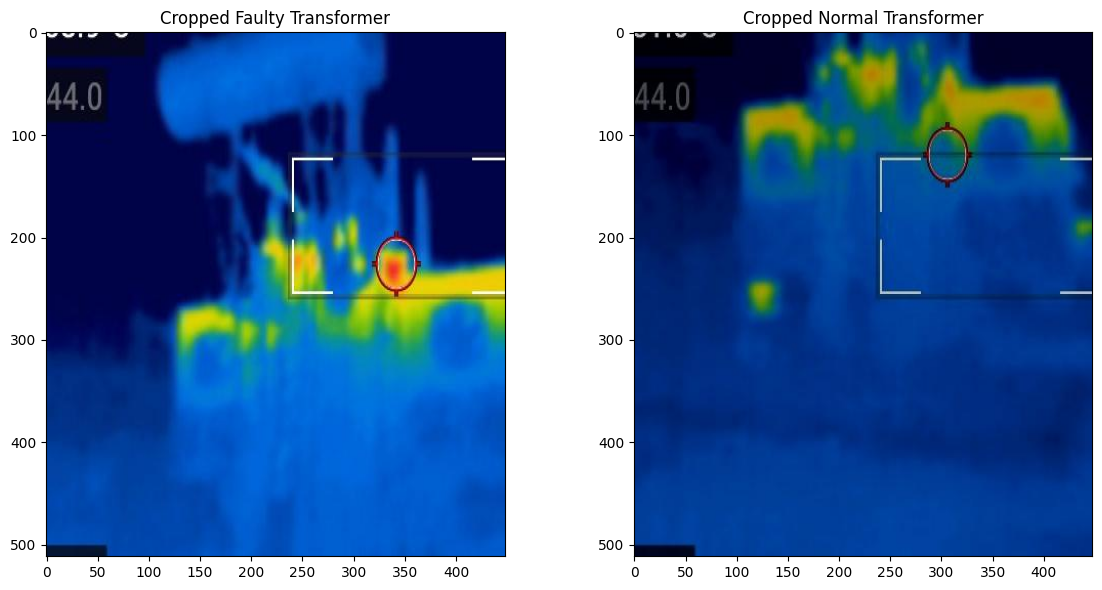

In [5]:
# Plot cropped images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Cropped Faulty Transformer")
plt.imshow(faulty_cropped_rgb)
plt.axis('on')

plt.subplot(1, 2, 2)
plt.title("Cropped Normal Transformer")
plt.imshow(normal_cropped_rgb)
plt.axis('on')

plt.tight_layout()
plt.show()

In [6]:
def calculate_thermal_score(img):
    """
    Calculate thermal score based on percentage of reddish pixels in the image.
    """
    # Convert to HSV for better color segmentation
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define red color range in HSV
    # Red has hue values around 0 or 180 in OpenCV HSV
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    
    # Create masks for red regions
    mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    
    # Combine masks
    red_mask = mask1 + mask2
    
    # Calculate red pixel percentage
    red_pixel_count = np.sum(red_mask > 0)
    total_pixel_count = red_mask.size
    red_percentage = (red_pixel_count / total_pixel_count) * 100
    
    return red_percentage, red_mask

# Calculate thermal scores
faulty_score, faulty_mask = calculate_thermal_score(faulty_cropped)
normal_score, normal_mask = calculate_thermal_score(normal_cropped)

print(f"Faulty transformer thermal score (red pixel %): {faulty_score:.2f}%")
print(f"Normal transformer thermal score (red pixel %): {normal_score:.2f}%")

Faulty transformer thermal score (red pixel %): 0.17%
Normal transformer thermal score (red pixel %): 0.01%


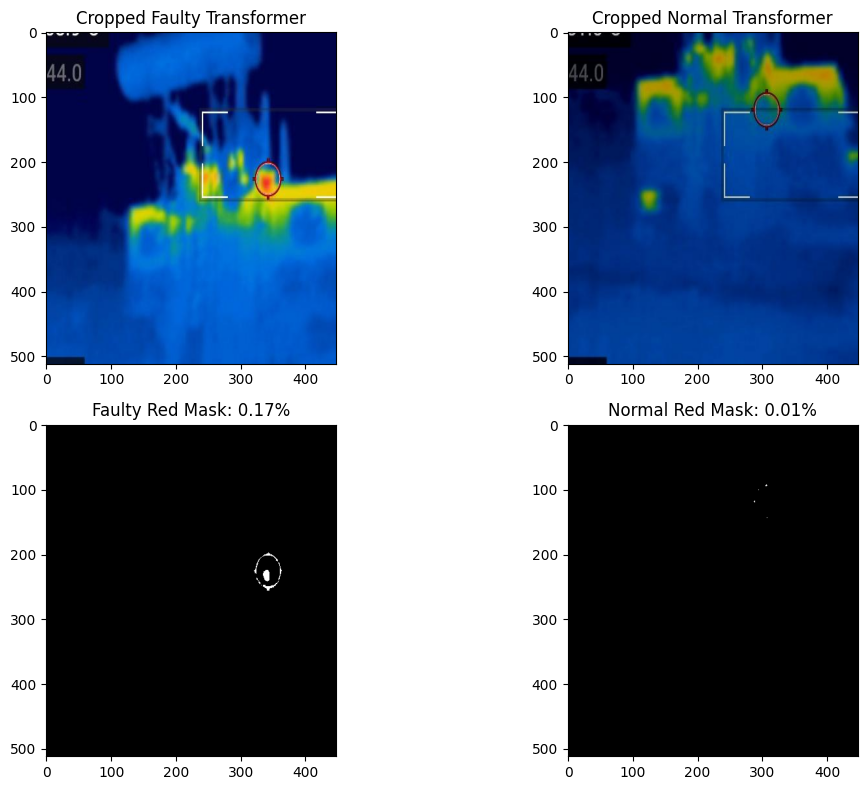

In [7]:
# Plot red masks
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Cropped Faulty Transformer")
plt.imshow(faulty_cropped_rgb)

plt.subplot(2, 2, 2)
plt.title("Cropped Normal Transformer")
plt.imshow(normal_cropped_rgb)

plt.subplot(2, 2, 3)
plt.title(f"Faulty Red Mask: {faulty_score:.2f}%")
plt.imshow(faulty_mask, cmap='gray')

plt.subplot(2, 2, 4)
plt.title(f"Normal Red Mask: {normal_score:.2f}%")
plt.imshow(normal_mask, cmap='gray')

plt.tight_layout()
plt.show()

In [10]:
def classify_transformer(thermal_score, threshold=5.0):
    """
    Classify transformer as faulty or normal based on thermal score.
    Args:
        thermal_score: Percentage of red pixels
        threshold: Threshold percentage above which transformer is classified as faulty
    Returns:
        Classification result and confidence
    """
    if thermal_score > threshold:
        return "FAULTY", thermal_score
    else:
        return "NORMAL", thermal_score

In [12]:
# Update threshold based on observed data
threshold = 0.1  # Updated from 5.0 to 0.1% based on actual measurements

# Classify transformers with updated threshold
faulty_result, faulty_confidence = classify_transformer(faulty_score, threshold)
normal_result, normal_confidence = classify_transformer(normal_score, threshold)

print(f"Faulty image classification: {faulty_result}")
print(f"Normal image classification: {normal_result}")

Faulty image classification: FAULTY
Normal image classification: NORMAL


In [26]:
def analyze_hotspot_pattern(mask, min_score=0.1):
    """
    Analyze the pattern of hotspots in the thermal image.
    
    Args:
        mask: Binary mask of detected hot regions
        min_score: Minimum thermal score to consider for analysis
        
    Returns:
        pattern_type: String describing the pattern type
        contours: List of contours found in the mask
    """
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no significant hotspots, return normal
    if len(contours) == 0:
        return "Normal", contours
    
    # Calculate area and shape metrics for the contours
    total_area = 0
    max_aspect_ratio = 0
    max_contour = None
    max_area = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        total_area += area
        
        # Find the contour with maximum area
        if area > max_area:
            max_area = area
            max_contour = contour
            
        # Calculate aspect ratio using minimum area rectangle
        if area > 10:  # Ignore very small contours
            rect = cv2.minAreaRect(contour)
            width, height = rect[1]
            if width > 0 and height > 0:
                aspect_ratio = max(width / height, height / width)
                max_aspect_ratio = max(max_aspect_ratio, aspect_ratio)
    
    # Calculate relative size of the hotspot
    mask_area = mask.shape[0] * mask.shape[1]
    relative_area = total_area / mask_area * 100
    
    # Determine pattern type
    if relative_area > 50:
        return "Transformer Overload (Faulty)", contours
    elif max_aspect_ratio > 10:
        return "Full Wire Overload (Potentially Faulty)", contours
    else:
        return "Point Overload (Faulty)", contours

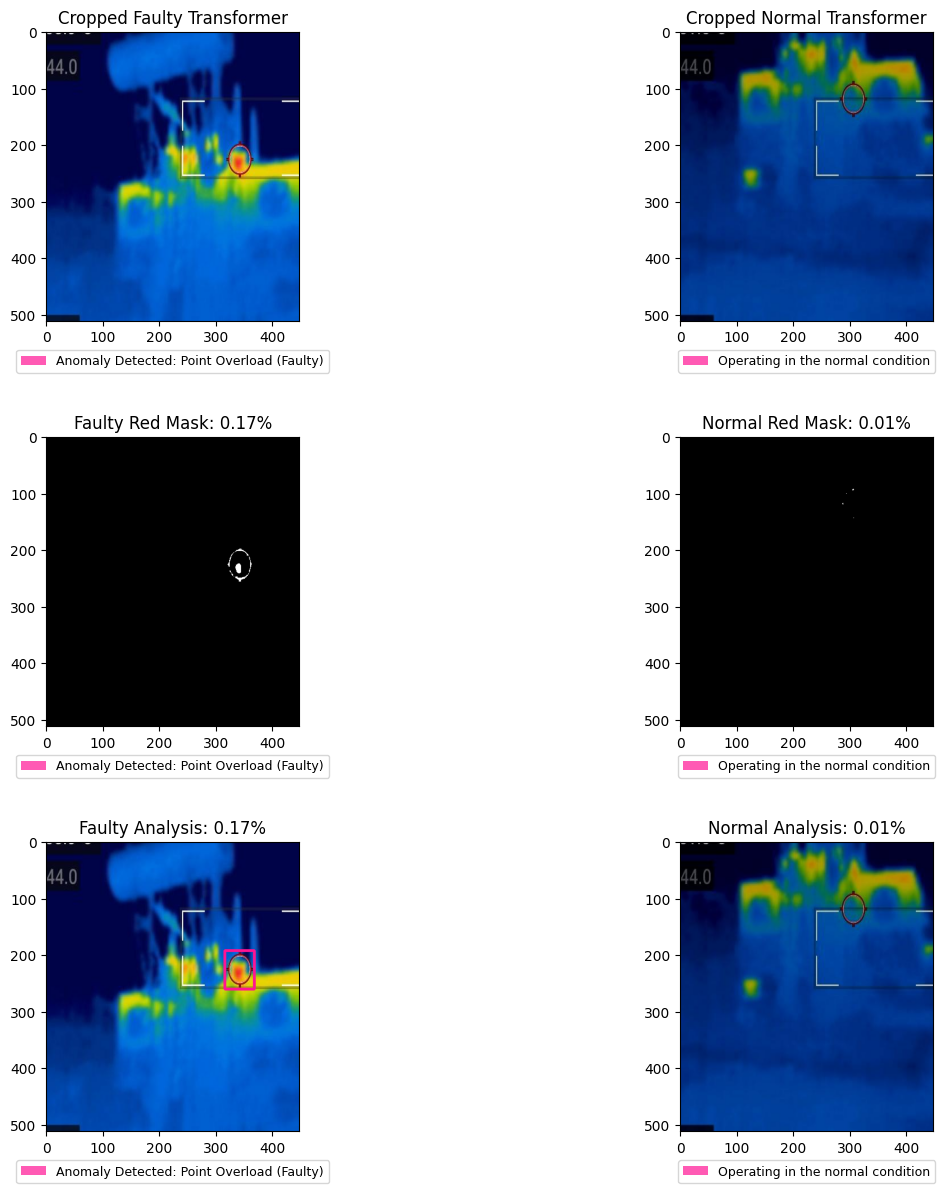

In [28]:
def visualize_thermal_analysis_single_box(img, mask, thermal_score, threshold=0.1, title=None):
    """
    Visualize thermal analysis with a single boundary box around all detected hotspots.
    Returns both the annotated image and legend text.
    
    Args:
        img: Original RGB image
        mask: Binary mask of detected hot regions
        thermal_score: Calculated thermal score
        threshold: Threshold for anomaly detection
        title: Optional title for the plot
        
    Returns:
        annotated_img: Image with boundary box
        legend_text: Text to display in legend
    """
    # Create a copy of the image for annotation
    annotated_img = img.copy()
    
    # Define pink color for annotations (in RGB)
    pink_color = (255, 20, 147)
    legend_text = ""
    
    if thermal_score >= threshold:
        # Find non-zero pixels in the mask (these are the red regions)
        non_zero_pixels = np.where(mask > 0)
        
        # If we have red pixels, create a bounding box
        if len(non_zero_pixels[0]) > 0:
            # Get min and max coordinates to create a bounding box
            min_y, max_y = np.min(non_zero_pixels[0]), np.max(non_zero_pixels[0])
            min_x, max_x = np.min(non_zero_pixels[1]), np.max(non_zero_pixels[1])
            
            # Add some padding to the box
            padding = 5
            min_x = max(0, min_x - padding)
            min_y = max(0, min_y - padding)
            max_x = min(img.shape[1] - 1, max_x + padding)
            max_y = min(img.shape[0] - 1, max_y + padding)
            
            # Draw rectangle with increased border width (changed from 2 to 4)
            cv2.rectangle(annotated_img, (min_x, min_y), (max_x, max_y), pink_color, 4)
            
            # Analyze hotspot pattern
            pattern, _ = analyze_hotspot_pattern(mask, threshold)
            legend_text = f"Anomaly Detected: {pattern}"
    else:
        legend_text = "Operating in the normal condition"
    
    return annotated_img, legend_text

# Create annotated images with a single boundary box
faulty_annotated_single, faulty_legend = visualize_thermal_analysis_single_box(
    faulty_cropped_rgb, 
    faulty_mask, 
    faulty_score, 
    threshold=0.1
)

normal_annotated_single, normal_legend = visualize_thermal_analysis_single_box(
    normal_cropped_rgb, 
    normal_mask, 
    normal_score, 
    threshold=0.1
)

# Create a more comprehensive visualization
plt.figure(figsize=(15, 12))

# Original cropped images
ax1 = plt.subplot(3, 2, 1)
plt.title("Cropped Faulty Transformer")
plt.imshow(faulty_cropped_rgb)
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax1.legend([pink_patch], [faulty_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

ax2 = plt.subplot(3, 2, 2)
plt.title("Cropped Normal Transformer")
plt.imshow(normal_cropped_rgb)
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax2.legend([pink_patch], [normal_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

# Red masks
ax3 = plt.subplot(3, 2, 3)
plt.title(f"Faulty Red Mask: {faulty_score:.2f}%")
plt.imshow(faulty_mask, cmap='gray')
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax3.legend([pink_patch], [faulty_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

ax4 = plt.subplot(3, 2, 4)
plt.title(f"Normal Red Mask: {normal_score:.2f}%")
plt.imshow(normal_mask, cmap='gray')
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax4.legend([pink_patch], [normal_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

# Annotated images with single boundary box
ax5 = plt.subplot(3, 2, 5)
plt.title(f"Faulty Analysis: {faulty_score:.2f}%")
plt.imshow(faulty_annotated_single)
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax5.legend([pink_patch], [faulty_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

ax6 = plt.subplot(3, 2, 6)
plt.title(f"Normal Analysis: {normal_score:.2f}%")
plt.imshow(normal_annotated_single)
# Add pink color patch for legend
pink_patch = plt.Rectangle((0,0), 1, 1, fc=(1, 0.08, 0.58), alpha=0.7)
ax6.legend([pink_patch], [normal_legend], loc='lower center', bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Increase space between rows to accommodate legends
plt.show()